In [1]:
import os
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd
import xarray as xr
import tensorflow as tf
import wandb 


from data_loader import load_datasets,load_and_average_dataset, find_cps, sample_indices_3sets, create_windows
from model import compile_and_fit,define_models,get_model,plot_variable_importance,plot_model_performance,plot_loss




2024-03-01 13:15:57.170622: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
IN_WIDTH=12
OUT_STEPS=6
SHIFT=0


In [3]:
fp='datasets/'
file1min = fp+'station_output.nc'
fileAveraged = fp+'WRF-10min.csv'
ds1min, dfAveraged = load_datasets(file1min,fileAveraged)
ds1min, dfAveraged = load_datasets(file1min,fileAveraged)

#ds1min, dfAveraged = load_and_average_dataset(file1min,averaging_interval='10min')



In [4]:
time_indices_split,Propagating_CPs_set, Not_propagating_CPs_set, Not_CPs_set=sample_indices_3sets(ds1min, dfAveraged, n_samples_beforeafterCPs=12)
len(time_indices_split['train'])


980

In [5]:
windows, num_features = create_windows(station_input='dakar_and_pout',
                                       all_data=dfAveraged,
                                       time_indices=time_indices_split,
                                       IN_WIDTH=IN_WIDTH,
                                       OUT_STEPS=OUT_STEPS,
                                       SHIFT=SHIFT)

for example_inputs, example_labels in windows.train.take(1):
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")

    
    
#windows.plot(ymin=290,ymax=305)






2024-03-01 13:16:06.525843: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-03-01 13:16:06.525878: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-03-01 13:16:06.525899: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (l40060.lvt.dkrz.de): /proc/driver/nvidia/version does not exist
2024-03-01 13:16:06.526149: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Inputs shape (batch, time, features): (128, 12, 10)
Labels shape (batch, time, features): (128, 6, 1)


In [6]:
# Call the function to define models
define_models(OUT_STEPS, num_features, lstm_units=200)




In [7]:
ARlstm=get_model('AR lstm')
lstm=get_model('lstm')


In [8]:
historyARlstm=compile_and_fit(ARlstm,windows)
historylstm=compile_and_fit(lstm,windows)


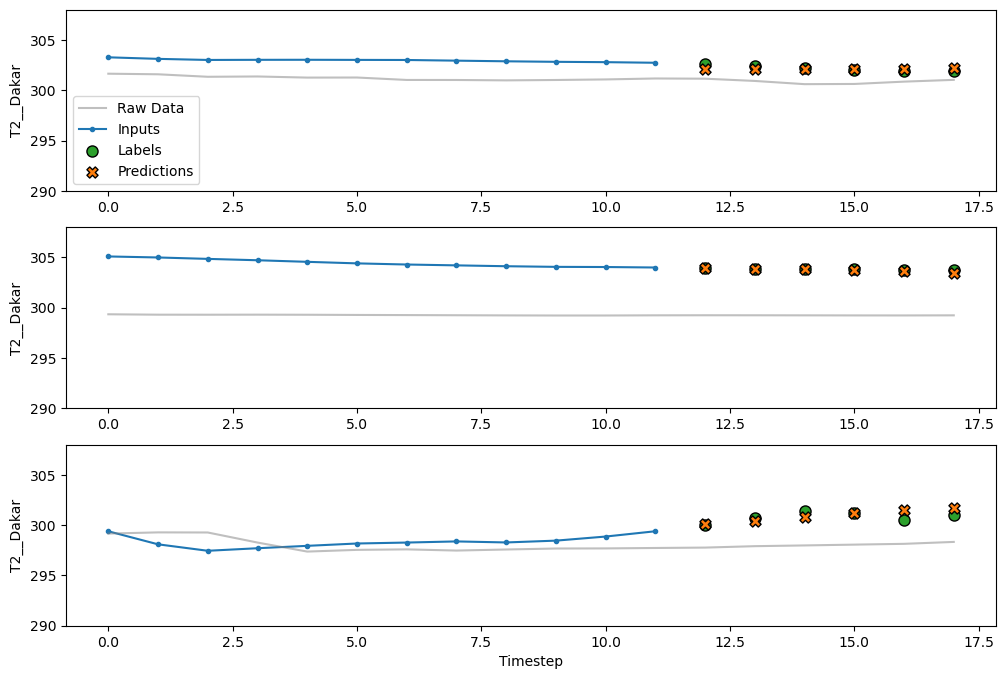

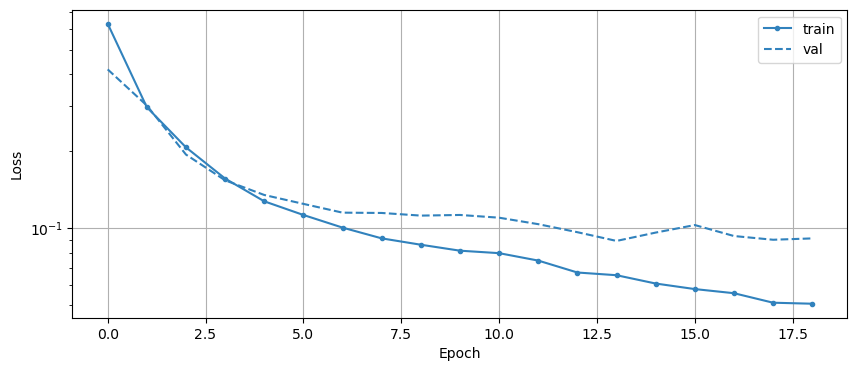

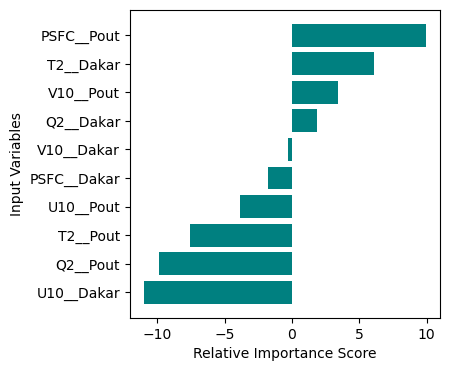

In [9]:
windows.plot(ARlstm, ymin=290, ymax=308)
plot_loss(historyARlstm)
plot_variable_importance(ARlstm,windows)


In [10]:
val_performance={}
test_performance={}
val_performance[ARlstm.name] = ARlstm.evaluate(windows.val)
val_performance[lstm.name] = lstm.evaluate(windows.val)
test_performance[ARlstm.name] = ARlstm.evaluate(windows.test)
test_performance[lstm.name] = lstm.evaluate(windows.test)

#performance[model.name] = model.evaluate(window.test, verboARlstm.evaluate(windows.val)se=0)

2/2 [==============================] - 0s 3ms/step - loss: 0.0527 - mean_absolute_error: 0.1647


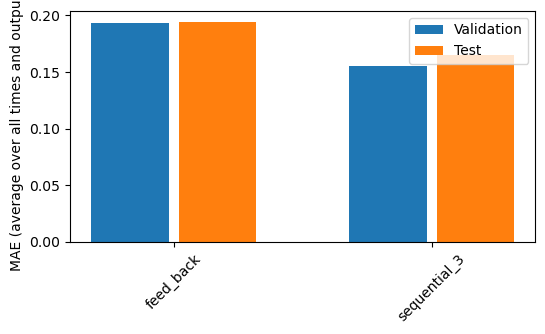

In [11]:
x = np.arange(len(val_performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in test_performance.values()]
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=val_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [12]:


prediction_steps=3
cps_dakar=find_cps(ds1min, dfAveraged, 'Dakar')
time_indices_for_inference = dict(train=[], val=[], test=cps_dakar-IN_WIDTH-prediction_steps)

windows_dakar,num_features=create_windows(station_input='dakar_and_pout',
                                           all_data=dfAveraged,
                                           time_indices=time_indices_for_inference,
                                           IN_WIDTH=IN_WIDTH,
                                           OUT_STEPS=OUT_STEPS,
                                           SHIFT=SHIFT)


In [13]:
ARlstm.evaluate(windows_dakar.test)
lstm.evaluate(windows_dakar.test)



1/1 [==============================] - 0s 49ms/step - loss: 0.3511 - mean_absolute_error: 0.4850


[0.3511478900909424, 0.4850102961063385]

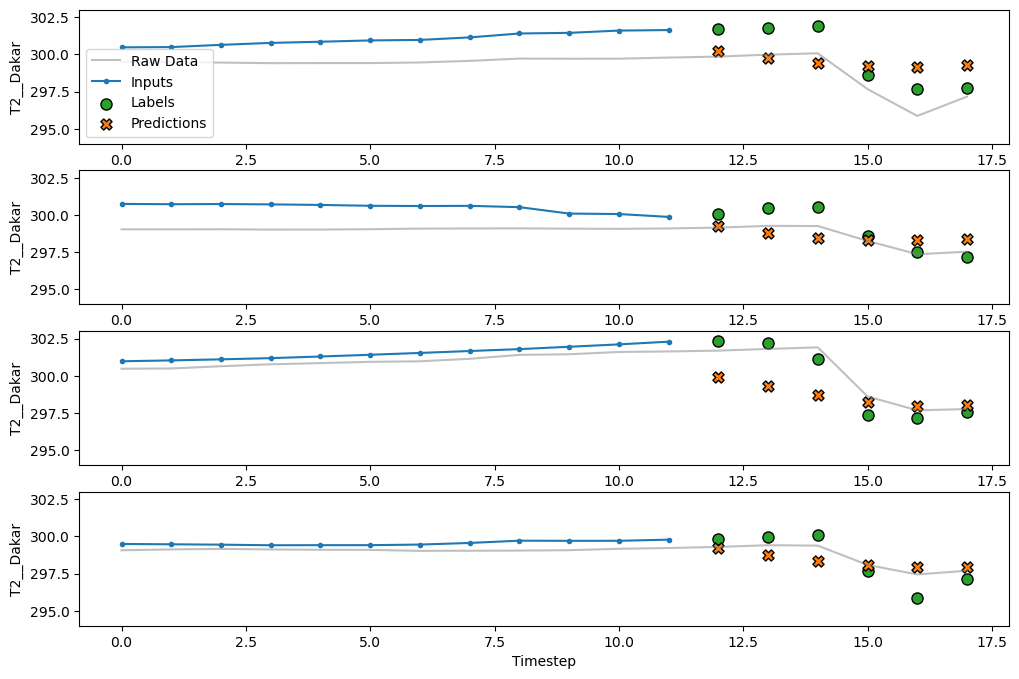

In [14]:
windows_dakar.plot(ARlstm, ymin=294,ymax=303,max_subplots=4)


In [15]:

prediction_steps=3

cps_dakar=find_cps(ds1min, dfAveraged, 'Dakar')
cps_pout=find_cps(ds1min, dfAveraged, 'Pout')



In [16]:
#test_cps_propagating = list(set(time_indices_split['test']).intersection(Propagating_CPs_set))
test_cps_propagating = list(set(time_indices_split['test']).intersection(cps_dakar))
propagating=dict(train=[], val=[], test=np.array(test_cps_propagating)-IN_WIDTH-prediction_steps)       
windows_propagating,num_features=create_windows(station_input='dakar_and_pout',
                                           all_data=dfAveraged,
                                           time_indices=propagating,
                                           IN_WIDTH=IN_WIDTH,
                                           OUT_STEPS=OUT_STEPS,
                                           SHIFT=SHIFT)
#test_cps_not_propagating = list(set(time_indices_split['test']).intersection(Not_propagating_CPs_set))
test_cps_not_propagating = list(set(time_indices_split['test']).intersection(set(cps_pout)).difference(Propagating_CPs_set))
not_propagating=dict(train=[], val=[], test=np.array(test_cps_not_propagating)-IN_WIDTH-prediction_steps)       
windows_not_propagating,num_features=create_windows(station_input='dakar_and_pout',
                                           all_data=dfAveraged,
                                           time_indices=not_propagating,
                                           IN_WIDTH=IN_WIDTH,
                                           OUT_STEPS=OUT_STEPS,
                                           SHIFT=SHIFT)



test_no_cps = list(set(time_indices_split['test']).intersection(Not_CPs_set))
no_cps=dict(train=[], val=[], test=np.array(test_no_cps)-IN_WIDTH-prediction_steps)       
windows_no_cps,num_features=create_windows(station_input='dakar_and_pout',
                                           all_data=dfAveraged,
                                           time_indices=no_cps,
                                           IN_WIDTH=IN_WIDTH,
                                           OUT_STEPS=OUT_STEPS,
                                           SHIFT=SHIFT)





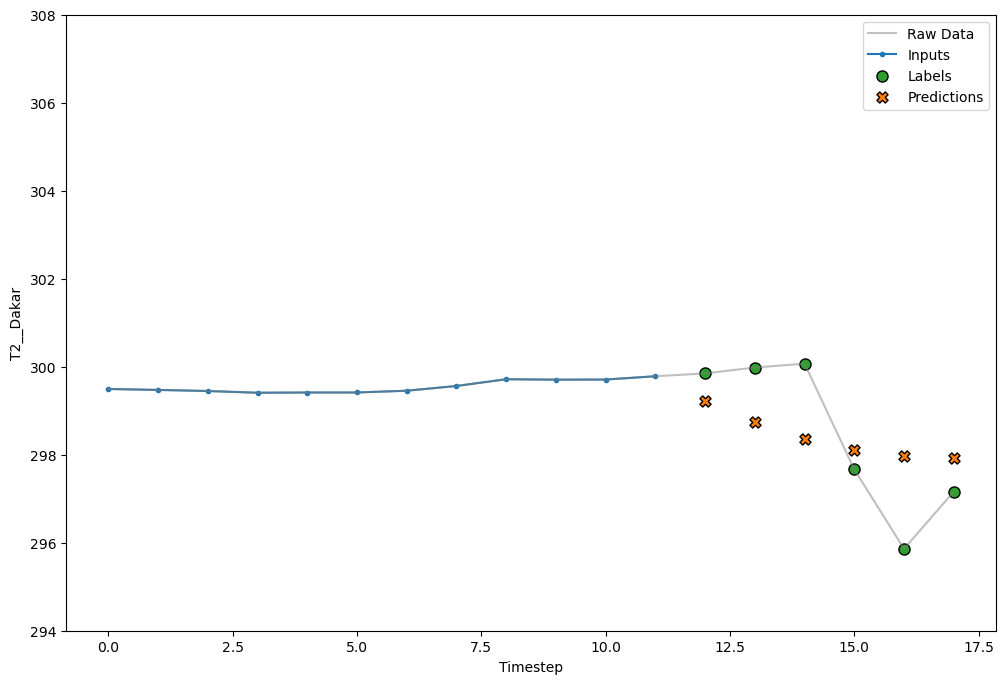

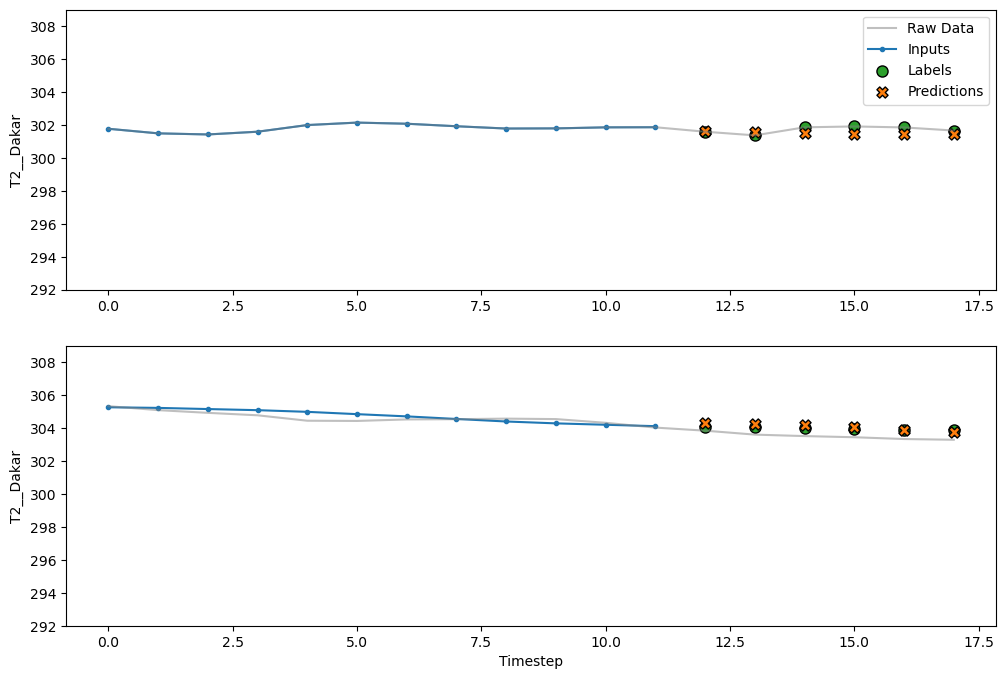

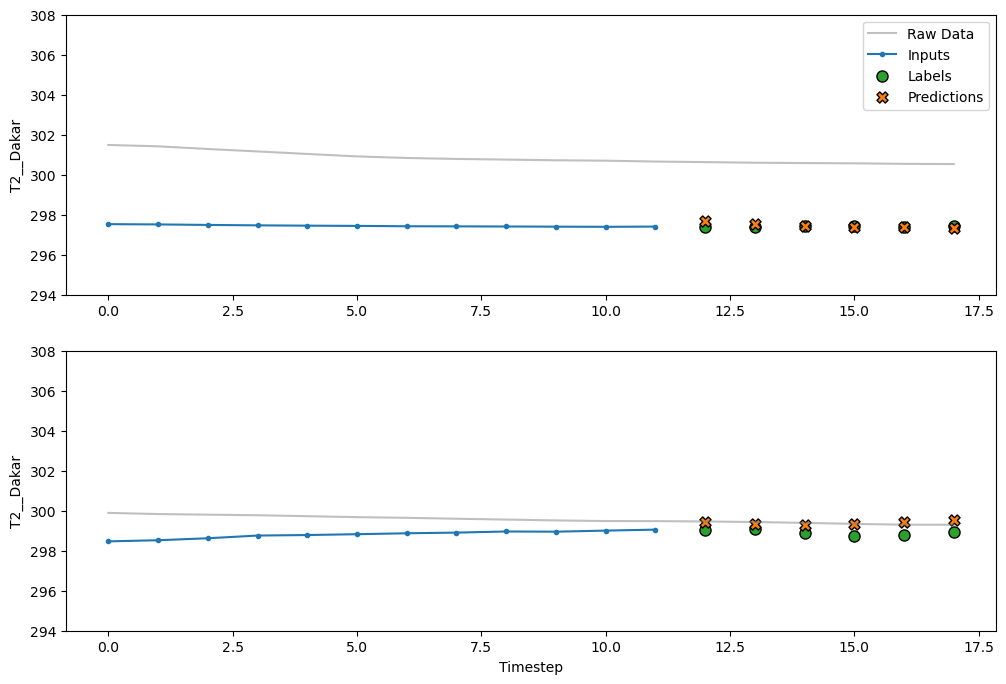

In [17]:

windows_propagating.plot(ARlstm, ymin=294,ymax=308,plot_col_input='T2__Dakar',max_subplots=2)
windows_not_propagating.plot(ARlstm, ymin=292,ymax=309,plot_col_input='T2__Dakar',max_subplots=2)
windows_no_cps.plot(ARlstm, ymin=294,ymax=308,plot_col_input='T2__Dakar',max_subplots=2)